<a href="https://colab.research.google.com/github/amirahhoss/DSproject/blob/main/SCRIPTS/1.Tweet_Sentiment_Analysis_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Below is code to produce sentiment analysis of Elon Musk's tweets using VADER.

Dataset: https://www.kaggle.com/datasets/gpreda/elon-musk-tweets

# Install Libraries

In [ ]:
!pip install pyspellchecker
!pip install scattertext
!pip install nltk
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 9.6 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=be1e133d1edd8be91d82873602a4f42aa81ae84c297a839e15b379c7378d4370
  Stored in directory: /root/.cache/pip/wheels/49/20/47/f03dfa8a7239c54cbc44ff7389eefbf888d2c1873edaaec888
Successfully built flashtext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.4 MB/s eta 0:00:00


# Import dependencies

In [ ]:
# Import Data Preprocessing and Wrangling libraries
import re
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil.parser

# Import NLP Libraries
import nltk
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Import Visualization Libraries
import plotly.offline as pyo
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random

# Downloading periphrals
nltk.download('vader_lexicon')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpreda/elon-musk-tweets")

print("Path to dataset files:", path)
import os
directory = '/root/.cache/kagglehub/datasets/gpreda/elon-musk-tweets/versions/336'

csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
df_list = []
for csv in csv_files:
    df = pd.read_csv(os.path.join(directory, csv))
    df_list.append(df)
sns.set_style('darkgrid')

# For sentiment analysis
sia = SIA()

# To identify misspelled words
spell = SpellChecker()

# To display plotly graphs
pyo.init_notebook_mode()

# Storing csv dataset into a datframe
df = pd.concat(df_list)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 369k/369k [00:00<00:00, 983kB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpreda/elon-musk-tweets/versions/336


## Explore tweets dataframe

In [ ]:
df.head()

id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified                       date  \
0           True  2022-07-05 17:55:09+00:00   
1           True  2022-07-05 17:47:42+00:00   
2           True  2022-07-05 17:46:15+00:00   
3           True  2022-07-05 17:40:05+00:00   
4           True  2022-07-05 17:38:23+00:00   

                                                text hashtags  \
0  @BillyM2k I find the gold toe sock – inevitabl...      NaN   
1                 Sock Con, the conference for socks      NaN   
2  Always something new for the magazine cover an...      NaN   
3                   @ExplainThisBob This guy gets it      NaN   
4  Sock tech is so advanced that you can get pret...      NaN   

               source  retweets  favorites  is_retweet  
0  Twitter for iPhone       335       6542       False  
1  Twitter for iPhone      1451      30753       False  
2  Twitter for iPhone      1284      28610       False  
3  Twitter for iPhone       131       3640       False  
4  Twitter for iPhone      1191      23790       False

## Create a copy of the old dataframe
So that the sentiment packages work later and the data is easier to work with

In [ ]:
data = df.copy()
data['original_tweet'] = df['text']
data['datetime'] = data['date']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))
rt_mask = data.text.apply(lambda x: "RT @" in x)

# standard tweet preprocessing
data.text = data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# convert the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)


# Viewing the preprocessed data
data.head()

id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified                       date  \
0           True  2022-07-05 17:55:09+00:00   
1           True  2022-07-05 17:47:42+00:00   
2           True  2022-07-05 17:46:15+00:00   
3           True  2022-07-05 17:40:05+00:00   
4           True  2022-07-05 17:38:23+00:00   

                                                text hashtags  \
0  i find the gold toe sock inevitably off kilter...      NaN   
1                  sock con the conference for socks      NaN   
2  always something new for the magazine cover an...      NaN   
3                                   this guy gets it      NaN   
4  sock tech is so advanced that you can get pret...      NaN   

               source  retweets  favorites  is_retweet  \
0  Twitter for iPhone       335       6542       False   
1  Twitter for iPhone      1451      30753       False   
2  Twitter for iPhone      1284      28610       False   
3  Twitter for iPhone       131       3640       False   
4  Twitter for iPhone      1191      23790       False   

                                      original_tweet            datetime  
0  @BillyM2k I find the gold toe sock – inevitabl... 2022-07-05 17:55:09  
1                 Sock Con, the conference for socks 2022-07-05 17:47:42  
2  Always something new for the magazine cover an... 2022-07-05 17:46:15  
3                   @ExplainThisBob This guy gets it 2022-07-05 17:40:05  
4  Sock tech is so advanced that you can get pret... 2022-07-05 17:38:23

# Perform the sentiment analysis on the tweets
Update the dataframe with overall sentiment and sentiment value columns

In [ ]:
def label_sentiment(x:float):
    if x < -0.05 : return 'negative'
    if x > 0.35 : return 'positive'
    return 'neutral'

# Feature Extraction
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))
data['errors'] = data.words.apply(spell.unknown)
data['errors_count'] = data.errors.apply(len)
data['words_count'] = data.words.apply(len)
data['sentence_length'] = data.text.apply(len)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data['date'] = data.datetime.apply(lambda x: x.date())
data['month'] = data.datetime.apply(lambda x: x.month)
data['year'] = data.datetime.apply(lambda x: x.year)


# Extract Sentiment Values for each tweet
data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
data['overall_sentiment'] = data['sentiment'].apply(label_sentiment);

  0%|          | 0/5904 [00:00<?, ?it/s]

# Exploring new datasets

In [ ]:
data.head()

id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified        date  ...  \
0           True  2022-07-05  ...   
1           True  2022-07-05  ...   
2           True  2022-07-05  ...   
3           True  2022-07-05  ...   
4           True  2022-07-05  ...   

                                               words  \
0  [i, find, the, gold, toe, sock, inevitably, of...   
1           [sock, con, the, conference, for, socks]   
2  [always, something, new, for, the, magazine, c...   
3                              [this, guy, gets, it]   
4  [sock, tech, is, so, advanced, that, you, can,...   

                                          errors errors_count  words_count  \
0  {corpo, arguablybit, outlittle, esthetically}            4           17   
1                                             {}            0            6   
2                                             {}            0           13   
3                                             {}            0            4   
4                                         {tech}            1           17   

   sentence_length  hour month  year sentiment overall_sentiment  
0              112    17     7  2022   -0.5423          negative  
1               33    17     7  2022    0.0000           neutral  
2               89    17     7  2022    0.0000           neutral  
3               16    17     7  2022    0.0000           neutral  
4               86    17     7  2022    0.7019          positive  

[5 rows x 28 columns]

#Exploratory Plots

In [ ]:
data['date'] = data['datetime'].dt.date  # Extract the date from the datetime column

# Now group by the date and count the number of tweets per day
tweets_per_day = data.groupby('date').size().reset_index(name='tweet_count')

# If you want it as a numpy array
tweets_per_day_array = tweets_per_day.to_numpy()

# Convert 'date' to a datetime object if needed
tweets_per_day['date'] = pd.to_datetime(tweets_per_day['date'])

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(tweets_per_day['date'], tweets_per_day['tweet_count'], linestyle='-', markersize=5)

# Add labels and title
plt.title('Number of Tweets per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust the layout to make sure labels are not cut off
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

Find count of sentiment score over the each month

overall_sentiment  negative  neutral  positive
year_month                                    
2022-07                  38      130        67
2022-08                  27      108        54
2022-09                  28      136        54
2022-10                  77      223       100
2022-11                 137      384       216
2022-12                 120      418       210
2023-01                  77      251       133
2023-02                  97      257       146
2023-03                 112      283       160
2023-04                 131      445       245
2023-05                  98      375       230
2023-06                   6       29        17


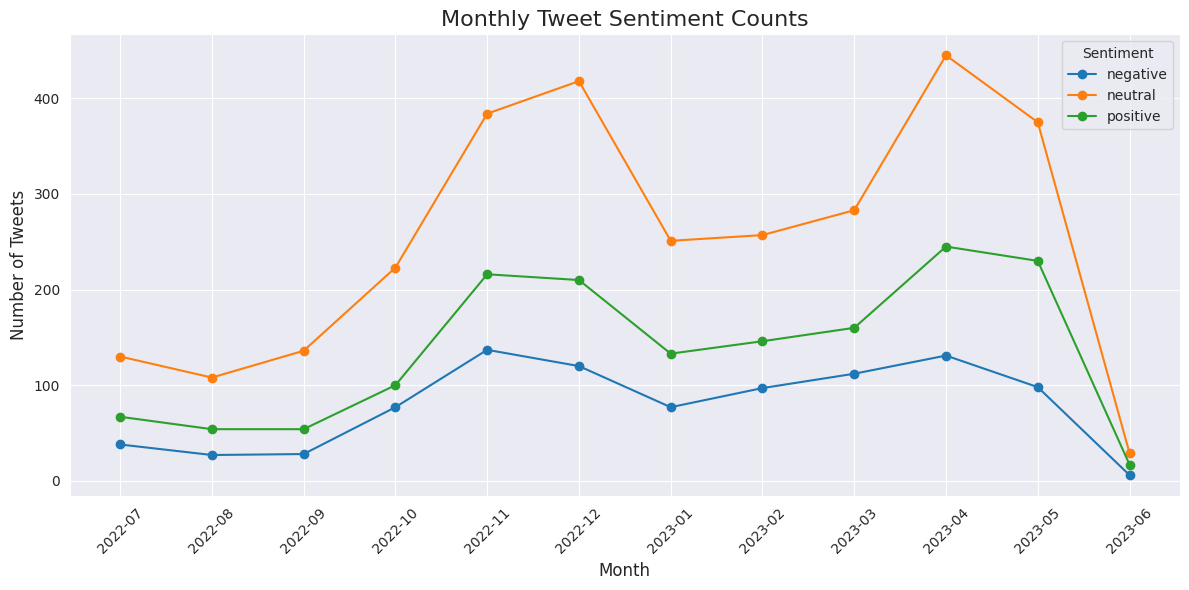

In [ ]:
# Ensure the 'datetime' column is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Filter the data to include only the desired date range
start_date = '2022-07-05'
end_date = '2023-06-03'
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]

# Extract the Year-Month for grouping
filtered_data['year_month'] = filtered_data['datetime'].dt.to_period('M')

# Group by 'year_month' and 'overall_sentiment' and count the number of tweets
monthly_sentiment_counts = filtered_data.groupby(['year_month', 'overall_sentiment']).size().reset_index(name='tweet_count')

# Pivot the table to get sentiment counts as separate columns for each month
monthly_sentiment_counts_pivot = monthly_sentiment_counts.pivot_table(index='year_month', columns='overall_sentiment', values='tweet_count', fill_value=0)

# Convert the sentiment counts to integers
monthly_sentiment_counts_pivot = monthly_sentiment_counts_pivot.astype(int)

# Display the resulting DataFrame
print(monthly_sentiment_counts_pivot)

# Plotting the sentiment counts
plt.figure(figsize=(12, 6))

# Plot each sentiment as a separate line
for sentiment in ['negative', 'neutral', 'positive']:
    plt.plot(monthly_sentiment_counts_pivot.index.astype(str), monthly_sentiment_counts_pivot[sentiment], label=sentiment, marker='o')

# Adding titles and labels
plt.title('Monthly Tweet Sentiment Counts', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


Visualize relationship between sentiment and user favourites

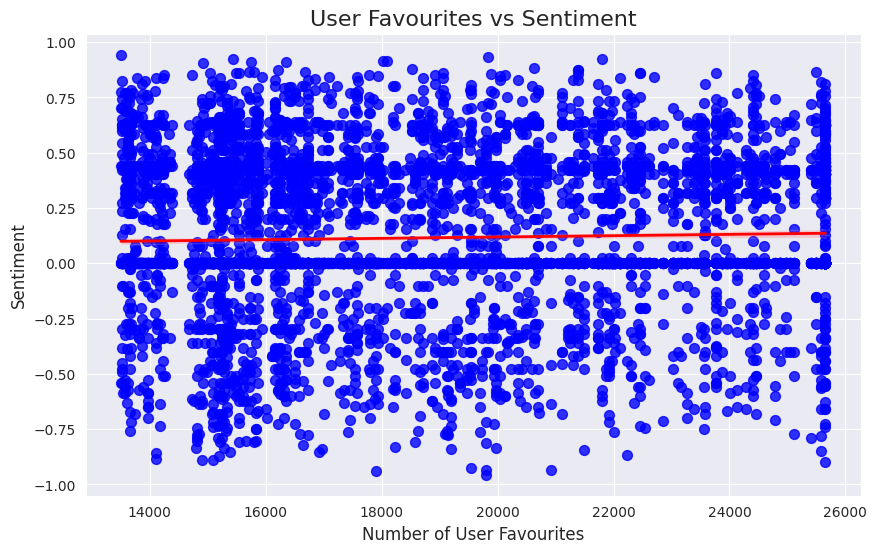

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='user_favourites', y='sentiment', data=data, scatter_kws={'s': 50, 'color': 'blue'}, line_kws={'color': 'red', 'lw': 2})

# Add labels and title
plt.title('User Favourites vs Sentiment', fontsize=16)
plt.xlabel('Number of User Favourites', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)

# Display the plot
plt.show()

Create wordbubble for each sentiment (positive, neutral, negative)

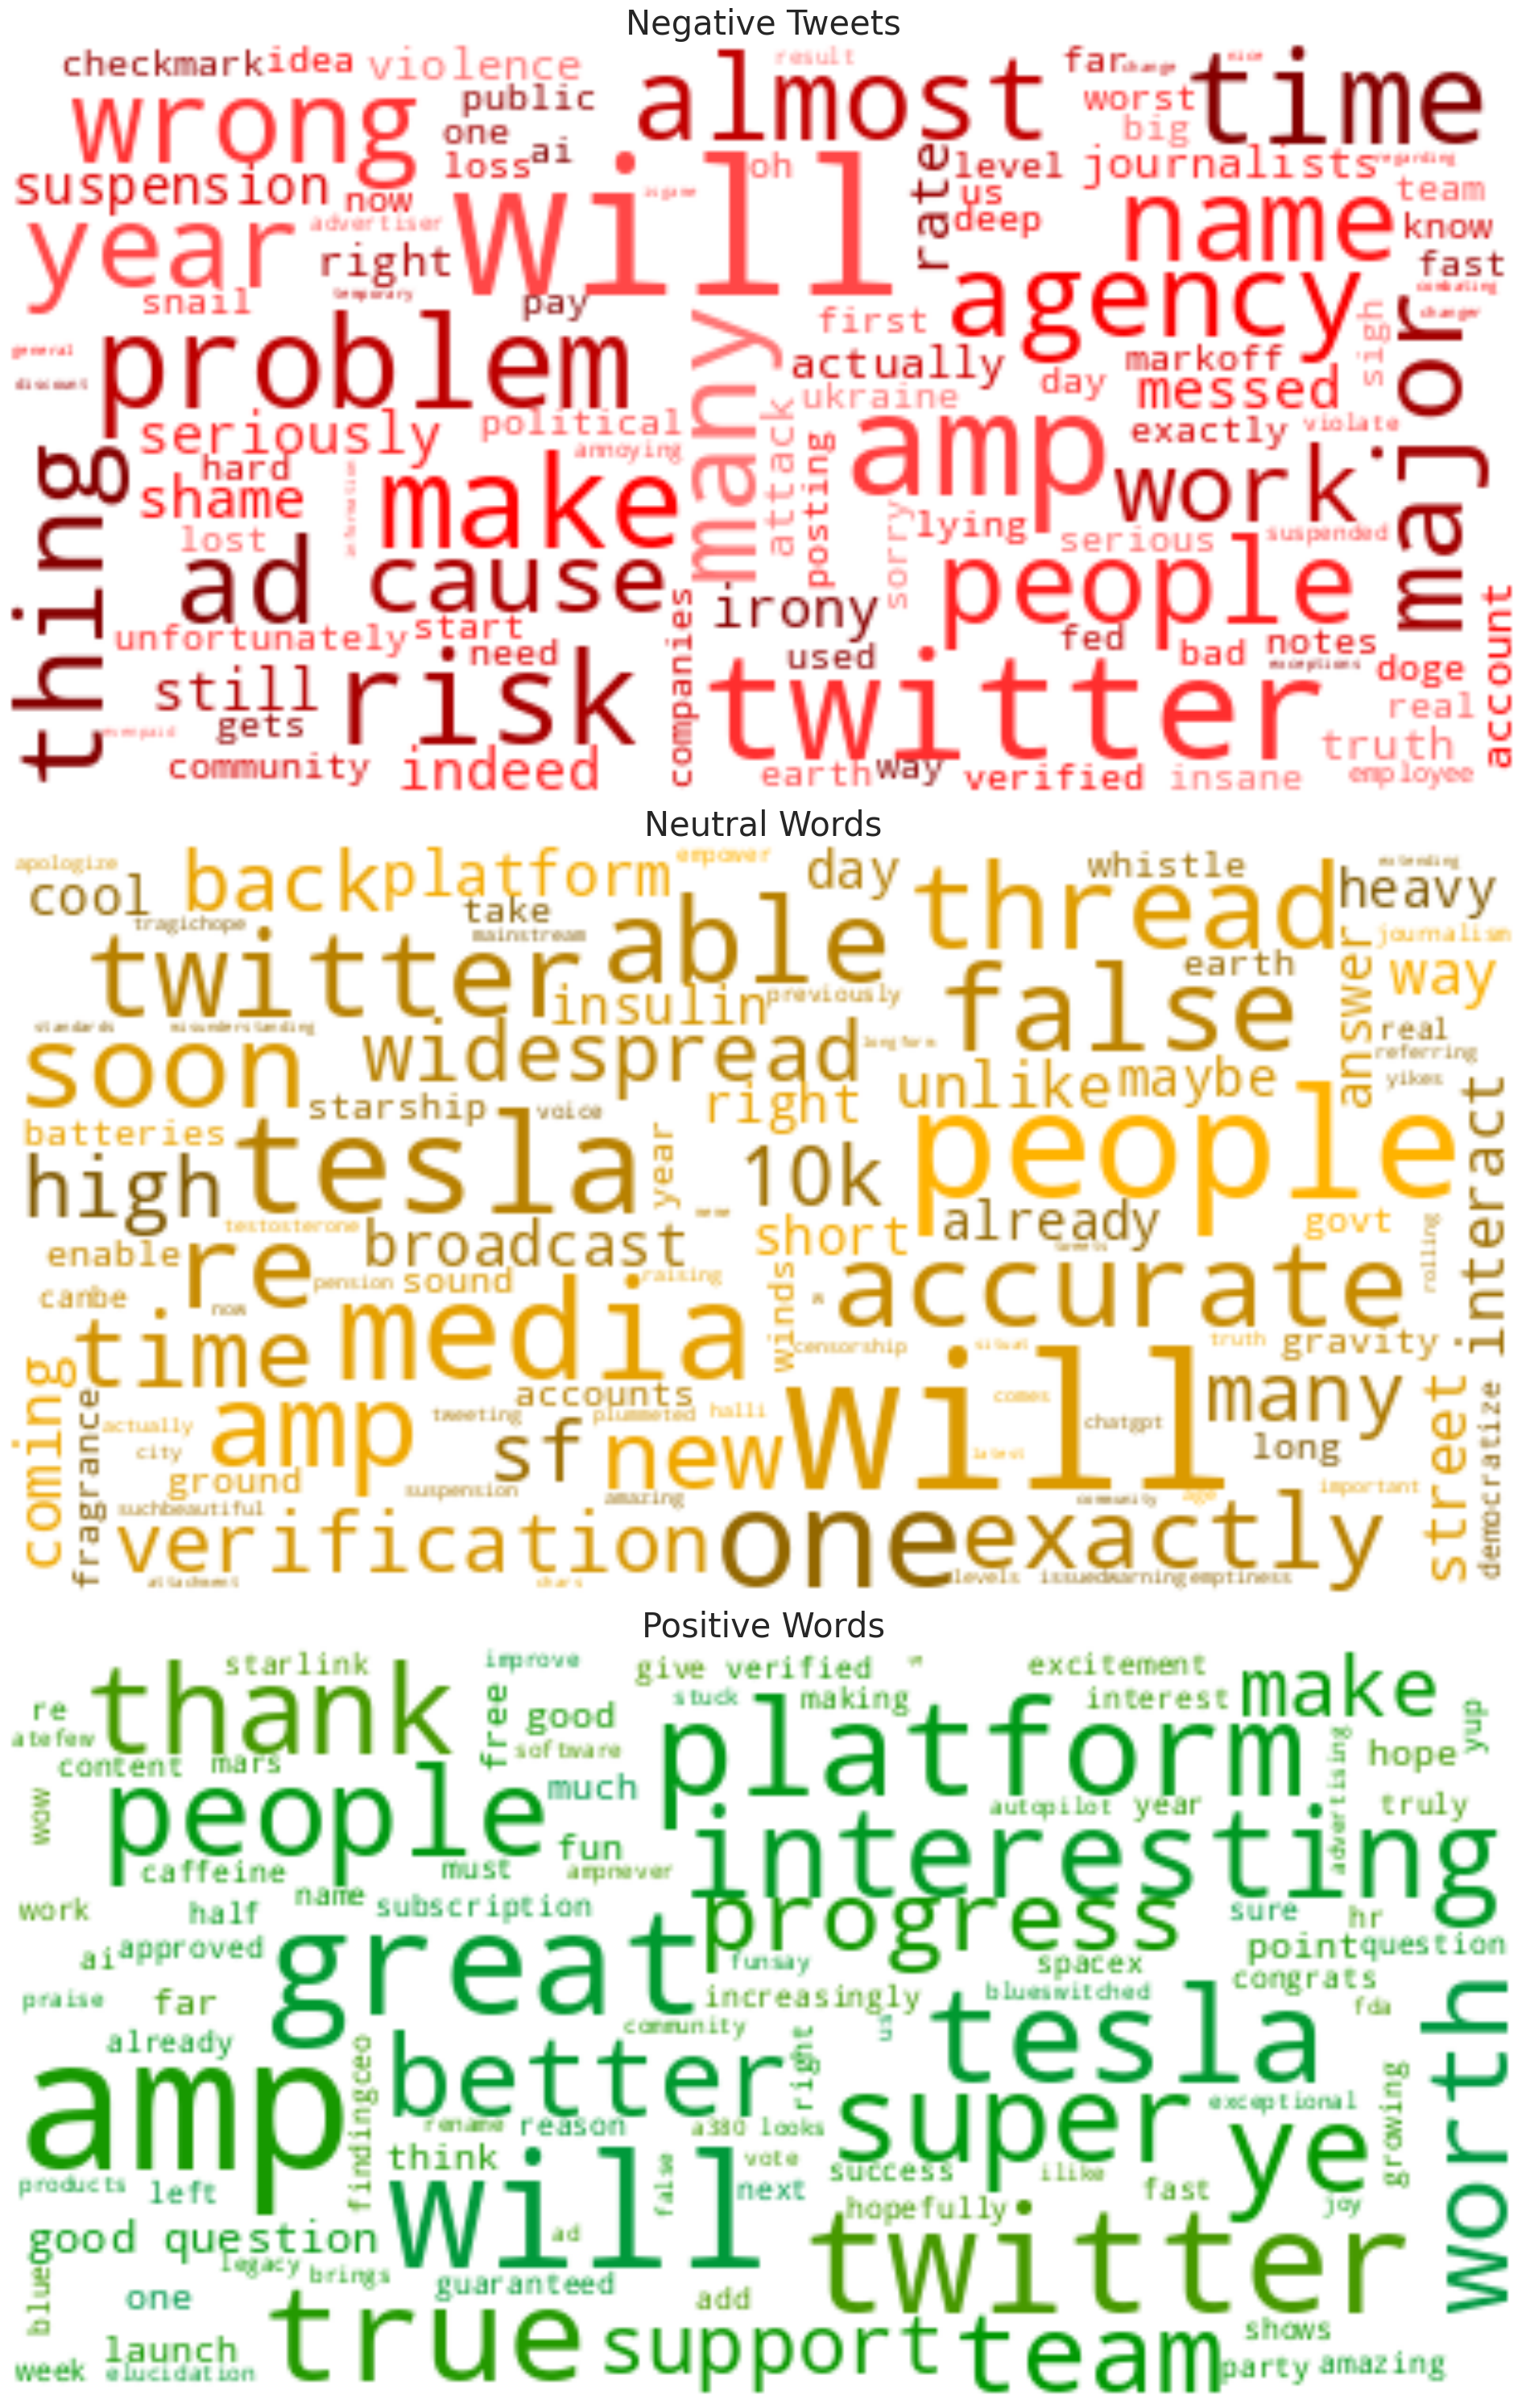

In [ ]:
def flatten_list(l):
    return [x for y in l for x in y]

# color coding our wordclouds
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)"

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)"

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)"

def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(3, 1, figsize=(20,30))

    # Flatten the list of lists before joining
    neg_doc = flatten_list(neg_doc)
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Tweets", fontsize=30)
    axes[0].axis("off")

    # Flatten the list of lists before joining
    neu_doc = flatten_list(neu_doc)
    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words", fontsize=30)
    axes[1].axis("off")

    # Flatten the list of lists before joining
    pos_doc = flatten_list(pos_doc)
    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words", fontsize=30)
    axes[2].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=1.5)
    # plt.style.use('dark_background')
    plt.show()
generate_word_clouds(negative_top_100.words, neutral_top_100.words, positive_top_100.words)